<a href="https://colab.research.google.com/github/YangxuanWu/Python/blob/master/NewProjectInFall/Data/DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/")

Mounted at /content/drive


In [2]:
!ls

 all_data.csv	    feaure_pics				   results
 attacks	    importance_list_all_data.csv	  'Yangxuan Wu.zip'
'Colab Notebooks'   importance_list_for_attack_files.csv


In [7]:
##  CICIDS2017 csv files are required for the operation of the program.
##  These files must be located under the "CSVs" folder in the same directory as the program.
##  The purpose of this program is to clear the csv files containing CICIDS2017 data from errors.
##  the faults observed are:
##      1-   288602 of the entries in the file "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv" are empty / meaningless.
##                   (e.g. ",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,")
##
##      2-  In the original csv files, while describing the Web Attack types such as Brute Force, XSS, Sql Injection, the character used is not recognized
##                    by the Python-Pandas library and leads to the error.
##                    this character ("–", Unicode code:8211) has been changed with another character ("-", Unicode code:45) to correct the error.
##
##   After the error correction, all the csv files were made into a single file (all_date.csv) to make it easier to process.

import pandas as pd
import os
from sklearn import preprocessing
import time
seconds = time.time()
%matplotlib inline

print("This process may take 5 to 10 minutes, depending on the performance of your computer.\n\n\n")
number="0123456789"
# CSV files names:
csv_files=["Monday-WorkingHours.pcap_ISCX",
        "Tuesday-WorkingHours.pcap_ISCX",
        "Wednesday-workingHours.pcap_ISCX",
        "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX",
        "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX",
        "Friday-WorkingHours-Morning.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX",]

# Headers of column
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","faulty-Fwd Header Length","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]

main_labels2=main_labels
main_labels=( ",".join( i for i in main_labels ) )
main_labels=main_labels+"\n"
flag=True
for i in range(len(csv_files)):
    ths = open(str(i)+".csv", "w")
    ths.write(main_labels)
    with open("./CSVs/"+csv_files[i]+".csv", "r", encoding='cp1252') as file:
        while True:
            try:
                line=file.readline()
                if  line[0] in number:# 这一行消除了CSV文件的头和不完整的流
                    if u"\u2013" in str(line): ##  如果流中有“-”字符(Unicode代码:8211)，则它将与“-”字符(Unicode代码:45)相邻
                        line=(str(line).replace(u"\u2013","-"))
                    ths.write(str(line))
                else:
                    continue                       
            except:
                break
    ths.close()
 
 
    df=pd.read_csv(str(i)+".csv",low_memory=False)
    df=df.fillna(0)

    string_features=["Flow Bytes/s","Flow Packets/s"]
    for ii in string_features: #“流字节/ s”和“流数据包/ s”列中的一些数据不是数字。修复这个循环中的bug
        df[ii]=df[ii].replace('Infinity', -1)
        df[ii]=df[ii].replace('NaN', 0)
        number_or_not=[]
        for iii in df[ii]:
            try:
                k=int(float(iii))
                number_or_not.append(int(k))
            except:
                number_or_not.append(iii)
        df[ii]=number_or_not



    string_features=[]
    for j in main_labels2: # 检测非数值(字符串和/或分类)属性(列)。
        if df[j].dtype=="object":
            string_features.append(j)
    try:
        string_features.remove('Label')#从列表中删除了“Label”属性。因为它必须对不同的机器学习方法保持“分类”。
    except:
        print("error!")
    labelencoder_X = preprocessing.LabelEncoder()



    for ii in string_features: ## 在此循环中，将非数字(字符串和/或分类)属性转换为数字特性。
        try:
            df[ii]=labelencoder_X.fit_transform(df[ii])
        except:
            df[ii]=df[ii].replace('Infinity', -1)
    df=df.drop(main_labels2[61], axis=1) ## 61列被删除，因为它是不必要的，41列(“Fwd头长度”特性)被错误地重写。



    ##All CSV files are merged into a single file.
    if flag:
        df.to_csv('all_data.csv' ,index = False)
        flag=False
    else:
        df.to_csv('all_data.csv' ,index = False,header=False,mode="a")
    os.remove(str(i)+".csv")
    print("The pre-processing phase of the ",csv_files[i]," file is completed.\n")
    

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")


This process may take 5 to 10 minutes, depending on the performance of your computer.



The pre-processing phase of the  Monday-WorkingHours.pcap_ISCX  file is completed.

The pre-processing phase of the  Tuesday-WorkingHours.pcap_ISCX  file is completed.

The pre-processing phase of the  Wednesday-workingHours.pcap_ISCX  file is completed.

The pre-processing phase of the  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX  file is completed.

The pre-processing phase of the  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX  file is completed.

The pre-processing phase of the  Friday-WorkingHours-Morning.pcap_ISCX  file is completed.

The pre-processing phase of the  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX  file is completed.

The pre-processing phase of the  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX  file is completed.

mission accomplished!
Total operation time: =  268.16365361213684 seconds


BENIGN                        2359289
DoS Hulk                       231073
PortScan                       158930
DDoS                            41835
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack - Brute Force         1507
Web Attack - XSS                  652
Infiltration                       36
Web Attack - Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64


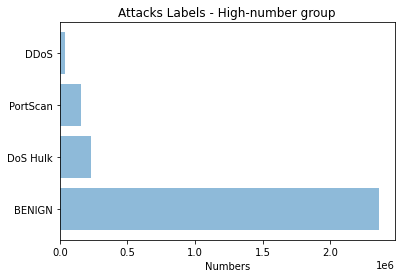

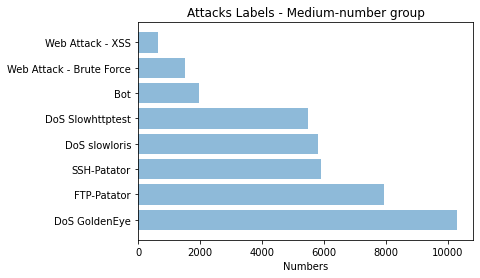

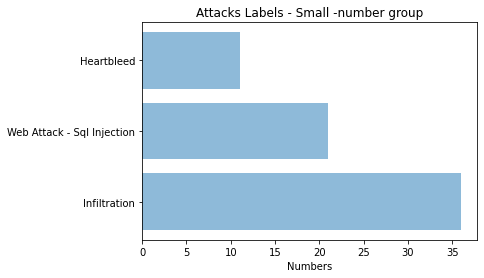

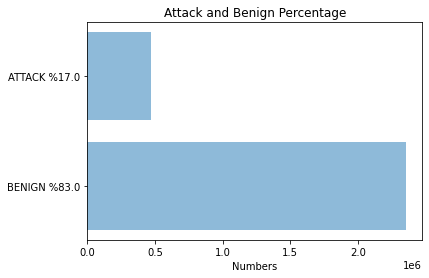

mission accomplished!
Total operation time: =  11.586140394210815 seconds


In [ ]:
##2.  all_data.csv files is required for the operation of the program.
##  all_data.csv file must be located in the same directory as the program.
##  
##  In the last graphics, the rates of all attacks and normal behaviors are given.



import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
%matplotlib inline
import time
seconds = time.time()

#  图创建函数
def graph(objects,performance,x_label,y_label):
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()


df=pd.read_csv('all_data.csv', usecols=["Label"])
print(df.iloc[:,0].value_counts())
a=(df.iloc[:,0].value_counts())



key=a.keys()
values=a.values
small_labels=[]
small_values=[]
big_labels=[]
big_values=[]
medium_labels=[]
medium_values=[]
attacak=0
benign=0


## 在本节中，攻击被分为3组，
##以便可以在图中看到所有值。
for i in range(0,len(values)):
    if values[i]>11000:
        big_labels.append(str(key[i]))
        big_values.append(values[i])
    elif values[i]<600:
        small_labels.append(str(key[i]))
        small_values.append(values[i]) 
    else:
        medium_labels.append(str(key[i]))
        medium_values.append(values[i])

    if str(key[i])=="BENIGN":
        benign+=values[i]
    else:
        attacak+=values[i]
        
key =[benign,attacak]


#函数被调用来创建一个特性
labels=["BENIGN %"+str(round(benign/(benign+attacak),2)*100),
        "ATTACK %"+str(round(attacak/(benign+attacak),2)*100)]
graph(big_labels,big_values,"Numbers","Attacks Labels - High-number group")
graph(medium_labels,medium_values,"Numbers","Attacks Labels - Medium-number group")
graph(small_labels,small_values,"Numbers","Attacks Labels - Small -number group")
graph(labels,key,"Numbers","Attack and Benign Percentage")



print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [ ]:
##3.程序的操作需要all_data.csv文件。csv文件必须位于与程序相同的目录中。这个程序的目的是生成只包含一种攻击和良性流的CSV文件。这些文件包含所有攻击流和一些良性数据流。发生率:(发作= 30%，良性=70%)，正常数据流是随机选择的

import random
import os
import pandas as pd
import time
seconds = time.time()
%matplotlib inline

def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        


print("This process may take 3 to 8 minutes, depending on the performance of your computer.\n\n\n")




# Headers of column
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]
main_labels=( ",".join( i for i in main_labels ) )

attacks=["BENIGN", "Bot", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris", "FTP-Patator", "Heartbleed", "Infiltration", "PortScan", "SSH-Patator", "Web Attack – Brute Force", "Web Attack – Sql Injection", "Web Attack – XSS"]
folder("./attacks/")

benign=2359289

dict_attack={
"Bot":1966,
"DDoS":41835,
"DoS GoldenEye":10293,
"DoS Hulk":231073,
"DoS Slowhttptest":5499,
"DoS slowloris":5796,
"FTP-Patator":7938,
"Heartbleed":11,
"Infiltration":36,
"PortScan":158930,
"SSH-Patator":5897,
"Web Attack - Brute Force":1507,
"Web Attack - XSS":652,
"Web Attack - Sql Injection":21}



for i in dict_attack: # 针对每种攻击类型打开一个文件，并以随机良性流记录。
    a,b=0,0
    ths = open("./attacks/"+i + ".csv", "w")
    ths.write(str(main_labels)+"\n")
    benign_num=int(benign/(dict_attack[i]*(7/3)))
    with open("all_data.csv", "r") as file:
        while True:
            try:
                line=file.readline()
                line=line[:-1]##去除这行文本最后一个字符（换行符），剩下的部分
                k=line.split(",")##通过“，”分割
                
                if k[83]=="BENIGN":
                    rnd=random.randint(1,benign_num)
                    if rnd==1:
                      ths.write(str(line)+"\n")
                      b+=1

                if k[83]==i:
                  ths.write(str(line)+"\n")
                  a+=1
                else:
                
                    continue                       
            except:
                break
    ths.close()
    print(i ,"file is completed\n attack:%d\n benign:%d\n\n\n " %(a,b))

##All web attack files are merged into a single file.
webs=["Web Attack - Brute Force","Web Attack - XSS","Web Attack - Sql Injection"]
flag=True
for i in webs:
    df=pd.read_csv("./attacks/"+str(i)+".csv")
    if flag:
        df.to_csv('./attacks/Web Attack.csv' ,index = False)
        flag=False
    else:
        df.to_csv('./attacks/Web Attack.csv' ,index = False,header=False,mode="a")
    os.remove("./attacks/"+str(i)+".csv")


print("mission accomplished!")
print("operation time: = ",time.time() - seconds ,"seconds")    


This process may take 3 to 8 minutes, depending on the performance of your computer.



Bot file is completed
 attack:1966
 benign:4658


 
DDoS file is completed
 attack:41835
 benign:98345


 
DoS GoldenEye file is completed
 attack:10293
 benign:24313


 
DoS Hulk file is completed
 attack:231073
 benign:589518


 
DoS Slowhttptest file is completed
 attack:5499
 benign:12862


 
DoS slowloris file is completed
 attack:5796
 benign:13491


 
FTP-Patator file is completed
 attack:7938
 benign:18710


 
Heartbleed file is completed
 attack:11
 benign:29


 
Infiltration file is completed
 attack:36
 benign:84


 
PortScan file is completed
 attack:158930
 benign:393550


 
SSH-Patator file is completed
 attack:5897
 benign:13782


 
Web Attack - Brute Force file is completed
 attack:1507
 benign:3475


 
Web Attack - XSS file is completed
 attack:652
 benign:1479


 
Web Attack - Sql Injection file is completed
 attack:21
 benign:29


 
mission accomplished!
operation time: =  232.043